# Table of Contents
1. Extract raw data
2. Logistic regression
3. Time series decomposition
4. Topic clustering

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import xml.etree.ElementTree as ET
import json
import os
import string
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

## 1. Extract raw data
Prepare a pandas dataframe containing all of the raw data provided for the exercise 

In [2]:
data_path = 'C:\\Users\\Shreye\\Documents\\data-scientist-exercise02\\data\\'

In [3]:
# Load XML file into dataframe
# https://stackoverflow.com/questions/41795198/more-efficient-conversion-of-xml-file-into-dataframe.
etree = ET.parse(data_path + 'AviationData.xml') 
data = []
for el in etree.iterfind('./*'):
    for i in el.iterfind('*'):
        data.append(dict(i.items()))       
aviation = pd.DataFrame(data)
aviation.shape

(77257, 31)

In [4]:
# Load JSON files into dataframe
narrative = pd.DataFrame()
all_jsons = [file for file in os.listdir(data_path) if file!='AviationData.xml'] # get a list of all of the JSON file names
for json_name in all_jsons:
    with open(data_path+json_name) as json_file: # read each JSON into a dataframe
        json_content = json_file.read()
        json_data = json.loads(json_content)
        json_df = pd.DataFrame(json_data['data']) # the "dataframe" is within the 'data' field of the JSON file
        narrative = pd.concat([narrative, json_df]) # concatenate all of the JSON dataframes
narrative.shape

(76133, 3)

In [5]:
# Merge the dataframes on the common EventId field
all_data = aviation.merge(narrative, how='left')
print(all_data.shape)
all_data.describe()

(77257, 33)


,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,EventDate,EventId,FARDescription,InjurySeverity,InvestigationType,Latitude,Location,Longitude,Make,Model,NumberOfEngines,PublicationDate,PurposeOfFlight,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition,narrative,probable_cause
count,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257
unique,77257,2814,13,4,9489,22284,3,13,174,15,12180,76133,17,120,2,16343,24702,17471,7204,11029,8,3403,23,67493,4,4,118,63,41,364,4,75557,47435
top,ENG02WA013,,,Substantial,,,No,LANDING,United States,Reciprocating,07/08/2000,20001212X19172,,Non-Fatal,Accident,,"ANCHORAGE, AK",,CESSNA,152,1,,Personal,,Probable Cause,,0,0,0,1,VMC,,
freq,1,73439,60737,55420,33780,29926,69198,18553,73076,63016,25,3,60592,58499,74207,53496,372,53505,16609,2251,61465,13188,43360,2756,72264,65878,40363,40342,42955,22029,68764,231,26754


> From all accidents, the most commmon phase of flight is LANDING and the most common aircraft is a Cessna 152

# 2. Modeling fatal vs non-fatal accidents
A logistic regression model can help explain factors that influence fatal aircraft accidents. To prepare for a regression analysis, the raw data needs to be cleaned to extract quantiative features. This is done manually for columns of interest: 
* Number of engines (numeric)
* Day of week (weekend/weekday)
* Weather condition (IMC/non-IMC) -- instrumental meteorological conditions implies poor visibility
* Purpose of flight (Personal/non-personal)
* Broad phase of flight (Landing/Takeoff/Standing/Cruising/reference) -- reference level is maneuvering, go-arounds, and unknowns

In [6]:
ntsb = all_data.copy()

In [7]:
ntsb['date'] = pd.to_datetime(ntsb['EventDate'], format="%m/%d/%Y", errors='coerce')

In [8]:
# Remove parentheses and digits from the InjurySeverity column to get a single level for "Fatal" incidents
ntsb.InjurySeverity = ntsb.InjurySeverity.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
ntsb.InjurySeverity = ntsb.InjurySeverity.apply(lambda x: x.translate(str.maketrans('','',string.digits)))

In [9]:
ntsb['engines'] = pd.to_numeric(ntsb['NumberOfEngines'], errors='coerce')
ntsb['engines'].fillna(ntsb.engines.mean(), inplace=True)

In [10]:
def fatal(data):
    if data['InjurySeverity'] == 'Fatal':
        return 1
    else:
        return 0

In [11]:
def weekend(data):
    if data['date'].weekday() < 5:
        return 0
    else:
        return 1

In [12]:
def imc(data):
    if data['WeatherCondition'] == 'IMC':
        return 1
    else:
        return 0

In [13]:
def personal(data):
    if data['PurposeOfFlight'] == 'Personal':
        return 1
    else:
        return 0

In [14]:
def landing(data):
    if data['BroadPhaseOfFlight'] == 'LANDING':
        return 1
    elif data['BroadPhaseOfFlight'] == 'APPROACH':
        return 1
    elif data['BroadPhaseOfFlight'] == 'DESCENT':
        return 1
    else:
        return 0

def takeoff(data):
    if data['BroadPhaseOfFlight'] == 'TAKEOFF':
        return 1
    elif data['BroadPhaseOfFlight'] == 'CLIMB':
        return 1
    elif data['BroadPhaseOfFlight'] == 'TAXI':
        return 1
    else:
        return 0

def standing(data):
    if data['BroadPhaseOfFlight'] == 'STANDING':
        return 1
    else:
        return 0
    
def cruising(data):
    if data['BroadPhaseOfFlight'] == 'CRUISE':
        return 1
    else:
        return 0

In [15]:
ntsb['fatal'] = ntsb.apply(fatal, axis=1)
ntsb['weekend'] = ntsb.apply(weekend, axis=1)
ntsb['imc'] = ntsb.apply(imc, axis=1)
ntsb['landing'] = ntsb.apply(landing, axis=1)
ntsb['takeoff'] = ntsb.apply(takeoff, axis=1)
ntsb['standing'] = ntsb.apply(standing, axis=1)
ntsb['cruising'] = ntsb.apply(cruising, axis=1)
ntsb['personal'] = ntsb.apply(personal, axis=1)

ntsb_reg = ntsb[['fatal', 'engines', 'personal', 'weekend', 'imc', 'landing', 'takeoff', 'standing', 'cruising']]
ntsb_reg.describe()

,fatal,engines,personal,weekend,imc,landing,takeoff,standing,cruising
count,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000
mean,0.199451,1.149095,0.561244,0.364122,0.072226,0.365210,0.248845,0.015054,0.137166
std,0.399590,0.451313,0.496238,0.481186,0.258864,0.481492,0.432346,0.121767,0.344024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
train_cols = ntsb_reg.columns[1:]

logit = sm.Logit(ntsb_reg['fatal'], ntsb_reg[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.436682
         Iterations 6


In [17]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fatal   No. Observations:                77257
Model:                          Logit   Df Residuals:                    77249
Method:                           MLE   Df Model:                            7
Date:                Fri, 10 May 2019   Pseudo R-squ.:                  0.1260
Time:                        13:57:56   Log-Likelihood:                -33737.
converged:                       True   LL-Null:                       -38601.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
engines       -0.4291      0.014    -31.193      0.000      -0.456      -0.402
personal       0.2255      0.019     11.770      0.000       0.188       0.263
weekend       -0.1107      0.020     -5.459      0.000      -0.150      -0.071
imc            2.1052      0.032     64.780      0.000       2.042       2.169
landing       -2.1019      0.026    -79.890      0.000      -2.153      -2.050
takeoff       -1.4890      0.026    -57.315      0.000      -1.540      -1.438
standing      -1.7809      0.100    -17.895      0.000      -1.976      -1.586
cruising      -1.0158      0.029    -35.344      0.000      -1.072      -0.960
==============================================================================
"""

In [18]:
np.exp(result.params) # odds ratios

engines     0.651074
personal    1.252993
weekend     0.895194
imc         8.209146
landing     0.122227
takeoff     0.225606
standing    0.168493
cruising    0.362098
dtype: float64

> The odds of IMC weather conditions resulting in a fatal accident are 8.21 greater than VMC or unknown weather

In [19]:
1/np.exp(result.params) # inverse odds ratios

engines     1.535923
personal    0.798089
weekend     1.117077
imc         0.121815
landing     8.181512
takeoff     4.432498
standing    5.934960
cruising    2.761681
dtype: float64

> The odds of landings being fatal are 8.18 less than if an aircraft is maneuvering, in a go-around, or unknown phase of flight

# 3. Trend and seasonality in accidents over time

In [28]:
ntsb = all_data.copy()
ntsb = ntsb[['EventDate', 'AccidentNumber']]
ntsb['EventDate'] = pd.to_datetime(ntsb['EventDate'], format="%m/%d/%Y", errors='coerce')
ntsb.dropna(subset=['EventDate'], inplace=True)
ntsb.index = ntsb['EventDate']

In [29]:
ntsb.head(10)

,EventDate,AccidentNumber
EventDate,,
2015-09-01,2015-09-01,GAA15CA244
2015-08-31,2015-08-31,CEN15LA392
2015-08-30,2015-08-30,GAA15CA246
2015-08-30,2015-08-30,GAA15CA243
2015-08-29,2015-08-29,GAA15CA242
2015-08-28,2015-08-28,WPR15LA253B
2015-08-28,2015-08-28,WPR15LA253A
2015-08-28,2015-08-28,CEN15LA387
2015-08-27,2015-08-27,WPR15LA251


In [30]:
# remove entries before 1982 and after 2014
ntsb = ntsb[(ntsb.EventDate >= pd.to_datetime('1982-01-01'))&(ntsb.EventDate < pd.to_datetime('2015-01-01'))]

In [31]:
# Count the number of incidents by month
ntsb_ts = ntsb.resample('M').count()['AccidentNumber']
ntsb_ts.head(24)

EventDate
1982-01-31    207
1982-02-28    232
1982-03-31    280
1982-04-30    303
1982-05-31    387
1982-06-30    349
1982-07-31    433
1982-08-31    399
1982-09-30    332
1982-10-31    239
1982-11-30    224
1982-12-31    208
1983-01-31    199
1983-02-28    210
1983-03-31    264
1983-04-30    273
1983-05-31    326
1983-06-30    392
1983-07-31    413
1983-08-31    421
1983-09-30    334
1983-10-31    269
1983-11-30    245
1983-12-31    210
Freq: M, Name: AccidentNumber, dtype: int64

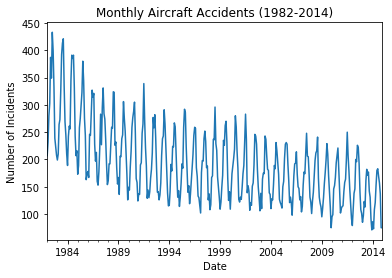

In [32]:
fig = ntsb_ts.plot()
fig.set_title('Monthly Aircraft Accidents (1982-2014)')
fig.set_xlabel('Date')
fig.set_ylabel('Number of Incidents')
fig

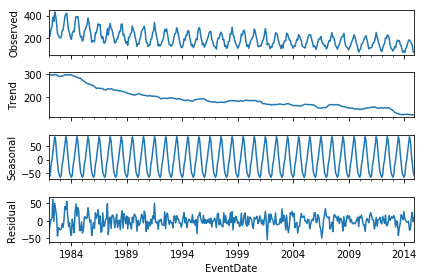

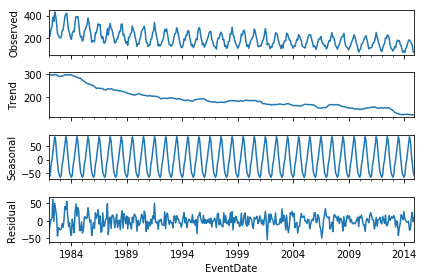

In [33]:
result = seasonal_decompose(ntsb_ts, model='additive', extrapolate_trend='freq')
result.plot()

In [34]:
(result.trend.min() - result.trend.max())/(2015-1982)

-5.300054743236557

In [35]:
result.seasonal.max() - result.seasonal.min()

150.40237014668833

> From 1982-2015 on average there are 5.3 fewer accidents every year, although there are ~150 more accidents in summer than winter